In [19]:
##importing libraries
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [20]:
##data loading and preprocessing
## Loading the dataset
def load_astronomy_data(__path__='/Users/dewangsahay/Desktop/Coding project/Astronomy project/Galaxy10_DECals.h5', max_images=1000):
    with h5py.File(__path__, 'r') as f:
        X = np.array(f['images'][:max_images])
        y = np.array(f['ans'][:max_images])
    print(f"Data shape: {X.shape}, Labels shape: {y.shape}")

    # Convert to grayscale
    X_gray = np.dot(X[...,:3], [0.2989, 0.5870, 0.1140])
    print(f"Grayscale data shape: {X_gray.shape}")

    # Map to 3 main classes
    def map_label(label):
        if label in [0, 4, 5]:  # Spiral types
            return 0
        elif label in [1, 2, 8, 9]:  # Elliptical types
            return 1
        else:  # Irregular/merging
            return 2

    y_mapped = np.array([map_label(label) for label in y])
    print(f"Mapped labels shape: {y_mapped.shape}")

    # normalizing / flattening the data
    X_gray = X_gray / 255.0  # Normalize to [0, 1]
    X_flat = X_gray.reshape(X_gray.shape[0], -1)
    return train_test_split(X_flat, y_mapped, test_size=0.2, random_state=42)

# Example usage:
X_train, X_test, y_train, y_test = load_astronomy_data()

Data shape: (1000, 256, 256, 3), Labels shape: (1000,)
Grayscale data shape: (1000, 256, 256)
Mapped labels shape: (1000,)


In [21]:
##NN functions 
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Stability improvement
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def cross_entropy(pred, labels):
    m = labels.shape[0]
    log_likelihood = -np.log(pred[range(m), labels] + 1e-8)
    loss = np.sum(log_likelihood) / m
    return loss

def one_hot(labels, num_classes):
    return np.eye(num_classes)[labels] 



In [22]:
##NN class
class NeuralNetwork:
    def __init__(self, input_size, hidden1, hidden2, output_size):
        self.W1 = np.random.randn(input_size, hidden1) * 0.01
        self.b1 = np.zeros((1, hidden1))
        self.W2 = np.random.randn(hidden1, hidden2) * 0.01
        self.b2 = np.zeros((1, hidden2))
        self.W3 = np.random.randn(hidden2, output_size) * 0.01
        self.b3 = np.zeros((1, output_size))

    def forward(self, X):
        self.Z1 = X.dot(self.W1) + self.b1
        self.A1 = relu(self.Z1)
        self.Z2 = self.A1.dot(self.W2) + self.b2
        self.A2 = relu(self.Z2)
        self.Z3 = self.A2.dot(self.W3) + self.b3
        self.A3 = softmax(self.Z3)
        return self.A3

    def backward(self, X, y_true, learning_rate=0.01):
        m = y_true.shape[0]
        y_onehot = one_hot(y_true, self.A3.shape[1])

        dZ3 = self.A3 - y_onehot
        dW3 = self.A2.T.dot(dZ3) / m
        db3 = np.sum(dZ3, axis=0, keepdims=True) / m

        dA2 = dZ3.dot(self.W3.T)
        dZ2 = dA2 * relu_derivative(self.Z2)
        dW2 = self.A1.T.dot(dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        dA1 = dZ2.dot(self.W2.T)
        dZ1 = dA1 * relu_derivative(self.Z1)
        dW1 = X.T.dot(dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        self.W3 -= learning_rate * dW3
        self.b3 -= learning_rate * db3
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1

In [23]:
## using libraries
nn = NeuralNetwork(input_size=X_train.shape[1], hidden1=128, hidden2=64, output_size=3)
epochs = 10
learning_rate = 0.01
for epoch in range(epochs):
    y_pred = nn.forward(X_train)
    loss = cross_entropy(y_pred, y_train)
    nn.backward(X_train, y_train, learning_rate)
    # Optionally print loss/accuracy
    if epoch % 1 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")        

Epoch 1/10, Loss: 1.1007
Epoch 2/10, Loss: 1.0929
Epoch 3/10, Loss: 1.0851
Epoch 4/10, Loss: 1.0775
Epoch 5/10, Loss: 1.0699
Epoch 6/10, Loss: 1.0623
Epoch 7/10, Loss: 1.0548
Epoch 8/10, Loss: 1.0473
Epoch 9/10, Loss: 1.0398
Epoch 10/10, Loss: 1.0324


In [25]:
# === Training Loop ===
def train_model():
    # Use already loaded data from previous cells
    global X_train, X_test, y_train, y_test
    input_size = X_train.shape[1]  # 69x69 = 4761
    model = NeuralNetwork(input_size=input_size, hidden1=128, hidden2=64, output_size=3)

    epochs = 30
    batch_size = 64
    learning_rate = 0.05

    for epoch in range(epochs):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = np.array(y_train)[indices]

        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            model.forward(X_batch)
            model.backward(X_batch, y_batch, learning_rate)

        # Evaluate
        preds = model.forward(X_test)
        y_pred = np.argmax(preds, axis=1)
        acc = np.mean(y_pred == y_test)
        loss = cross_entropy(preds, y_test)
        print(f"Epoch {epoch+1}: Test Loss={loss:.4f}, Accuracy={acc*100:.2f}%")
    return model

model = train_model()
print("Training complete. Model ready for predictions.")
print("W1 shape:", model.W1.shape)
print("W2 shape:", model.W2.shape)
print("W3 shape:", model.W3.shape)
print("b1 shape:", model.b1.shape)
print("b2 shape:", model.b2.shape)
print("b3 shape:", model.b3.shape)

Epoch 1: Test Loss=0.0441, Accuracy=100.00%
Epoch 2: Test Loss=0.0040, Accuracy=100.00%
Epoch 3: Test Loss=0.0018, Accuracy=100.00%
Epoch 4: Test Loss=0.0011, Accuracy=100.00%
Epoch 5: Test Loss=0.0008, Accuracy=100.00%
Epoch 6: Test Loss=0.0006, Accuracy=100.00%
Epoch 7: Test Loss=0.0005, Accuracy=100.00%
Epoch 8: Test Loss=0.0004, Accuracy=100.00%
Epoch 9: Test Loss=0.0004, Accuracy=100.00%
Epoch 10: Test Loss=0.0003, Accuracy=100.00%
Epoch 11: Test Loss=0.0003, Accuracy=100.00%
Epoch 12: Test Loss=0.0002, Accuracy=100.00%
Epoch 13: Test Loss=0.0002, Accuracy=100.00%
Epoch 14: Test Loss=0.0002, Accuracy=100.00%
Epoch 15: Test Loss=0.0002, Accuracy=100.00%
Epoch 16: Test Loss=0.0002, Accuracy=100.00%
Epoch 17: Test Loss=0.0002, Accuracy=100.00%
Epoch 18: Test Loss=0.0001, Accuracy=100.00%
Epoch 19: Test Loss=0.0001, Accuracy=100.00%
Epoch 20: Test Loss=0.0001, Accuracy=100.00%
Epoch 21: Test Loss=0.0001, Accuracy=100.00%
Epoch 22: Test Loss=0.0001, Accuracy=100.00%
Epoch 23: Test Loss

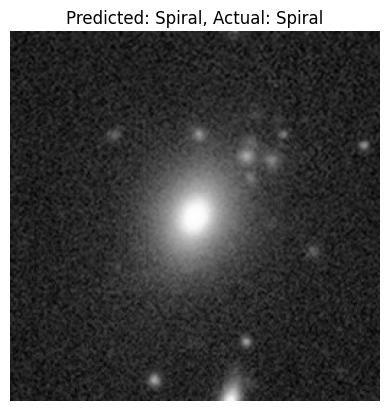

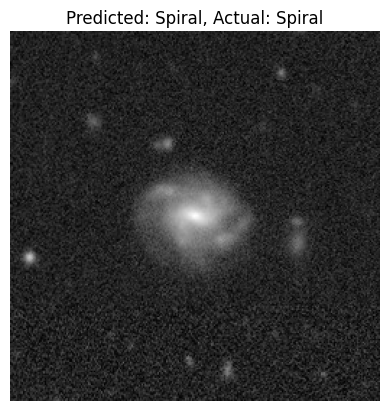

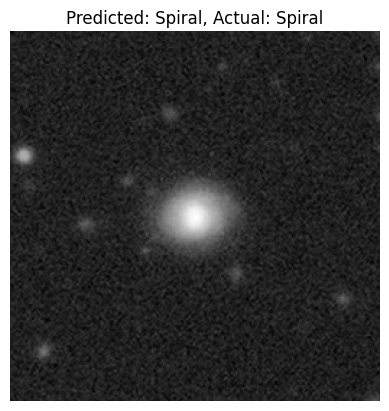

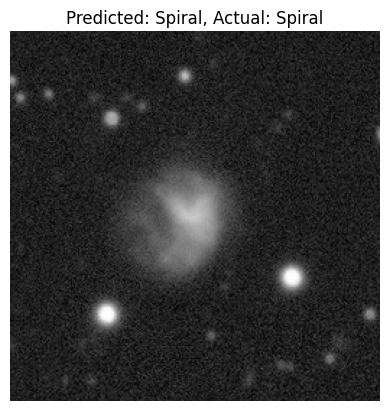

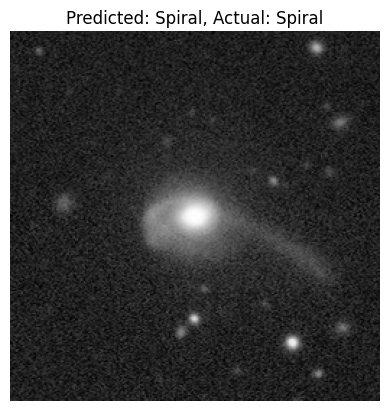

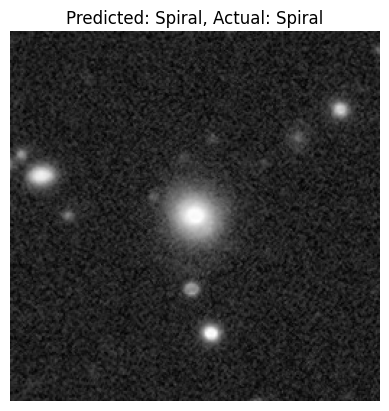

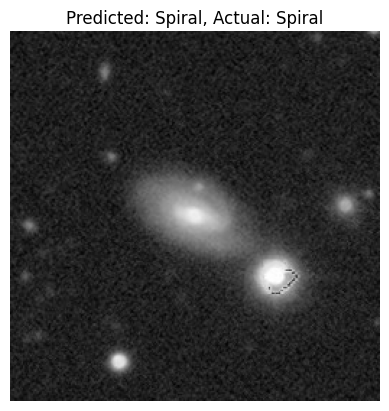

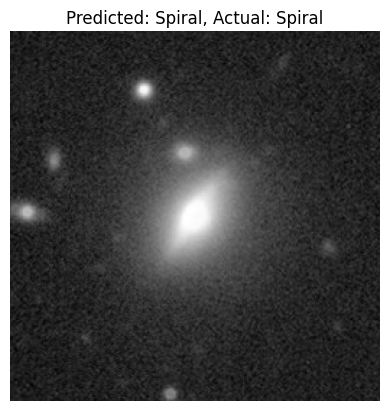

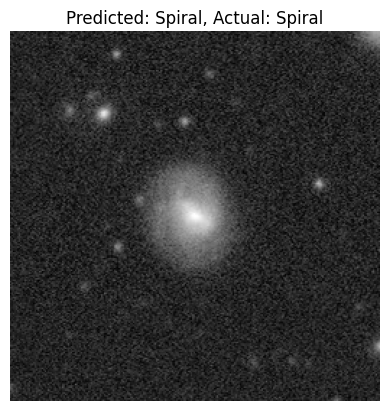

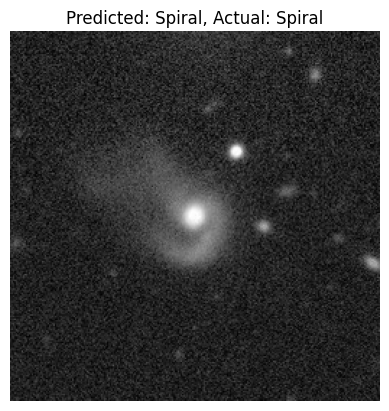

In [27]:
##show results
label_map = {
    0: "Spiral",
    1: "Elliptical",
    2: "Irregular"
}

def show_predictions(model, X, y_true, num_samples=10):
    preds = model.forward(X)
    y_pred = np.argmax(preds, axis=1)

    for i in range(num_samples):
        plt.imshow(X[i].reshape(256, 256), cmap='gray')
        plt.title(f"Predicted: {label_map[y_pred[i]]}, Actual: {label_map[y_true[i]]}")
        plt.axis('off')
        plt.show()

show_predictions(model, X_test, y_test, num_samples=10)
